# **0 Befor Running:**

If you are running this tutorial on google colab, make sure to set runtime type to gpu, which will accelerate the running speed.

If you are running this tutorial locally, make sure you have already setup python3 + jupyter notebook environments.

# **1 Download Materials**


> ***(All the materials are downloaded from my personal github repositoty.)***

Materials downloaded includes:



*   Basic source codes (concrete codes please check [my personal github repository](https://github.com/Askfk/maca.git))
*   Required packages
*   Well-trained weights
*   CocoVG dataset


---



Basic source code directory named maca will be download to `"../content/maca/"`

Well-trained weights **maca_cocovg.hdf5** will be downloaded to `"../content/maca/weights/maca_cocovg.hdf5"`

CocoVG dataset will be downloaded and unzipped to `"../content/maca/CocoVG/"`


## **1.1 Download basic source code**

In [1]:
# Download basic source code
!git clone https://github.com/Askfk/maca.git

Cloning into 'maca'...
remote: Enumerating objects: 202, done.
remote: Counting objects: 100% (202/202), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 202 (delta 63), reused 158 (delta 32), pack-reused 0
Receiving objects: 100% (202/202), 36.32 MiB | 12.05 MiB/s, done.
Resolving deltas: 100% (63/63), done.


## **1.2 Download and import required packages**
These packages requirements are all wrote in requirements.txt, required packages include **tensorflow == 2.3.0, scipy, numpy, matplotlib, pillow, absl-py, pycocotools, six, keras_applications and skimage**. If there is any packages required in follow codes than cannot be donwloaded successfully here, please download them manully by **!pip install packagename**

In [2]:
# Install all required packages
!pip install -r /content/maca/requirements.txt

     |████████████████████████████████| 51kB 1.6MB/s 


In [3]:
# import necessary packages and setup project path
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import tensorflow as tf
import colorsys
import imutils
from PIL import Image
import skimage

print(tf.__version__)

# Initialize the file path
ROOT_DIR = os.path.abspath("/content")
if not os.path.exists(ROOT_DIR):
    os.mkdir(ROOT_DIR)

MACA_DIR = os.path.join(ROOT_DIR, 'maca')
WEIGHT_DIR = os.path.join(MACA_DIR, 'weights')
DATASET_DIR = os.path.join(MACA_DIR, 'COCOVG')
IMAGE_DIR = os.path.join(MACA_DIR, 'pics')
OUTPUT_DIR = os.path.join(ROOT_DIR, 'outputs')
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
VIDEO_DIR = os.path.join(MACA_DIR, 'video')

sys.path.append(ROOT_DIR)  # To find local version of the library

from maca.macacripts import utils
from maca.macacripts import visualize
import maca.MACA as MACA
from maca.macacripts.utils import log
from maca.config import Config
from maca.macacripts.cocovg import CocoVGConfig, CocoVGDataset
from maca.pycocoevalcap.eval import eval

MODEL_DIR = os.path.join(ROOT_DIR, "logs")
WEIGHT_PATH = os.path.join(WEIGHT_DIR, "maca_cocovg.hdf5")

2.3.0


## **1.3 Download well-trained weights**

Well-trained weights maca_cocovg.hdf5 will be downloaded to **/content/maca/weights/maca_cocovg.hdf5**

In [4]:
if not os.path.exists(WEIGHT_DIR):
    os.mkdir(WEIGHT_DIR)
    utils.download_trained_weights(WEIGHT_PATH)

... done downloading pretrained model!


## **1.4 Download CocoVG dataset**

CocoVG dataset zip file will be downloaded to **/content** and then be unzipped to **/content/maca/COCOVG/**

In [5]:
if not os.path.exists(DATASET_DIR):
    utils.download_dataset("/content/cocovg.zip")
    print("Now unzipping cocovg.zip...")
    !unzip -uq '/content/cocovg.zip' -d "/content/maca"
    print("...done unzipping!")

... done downloading dataset!
Now unzipping cocovg.zip...
...done unzipping!


# **2 Initialize materials**


*   Dataset
*   Tokenizer
*   Model
*   Plot model architecture



## **2.1 Initialize dataset**

Initialize train dataset and validation dataset

In [6]:
dataset_train = CocoVGDataset()
dataset_train.initalize_dataset(DATASET_DIR, 'train')
dataset_train.prepare()

dataset_val = CocoVGDataset()
dataset_val.initalize_dataset(DATASET_DIR, 'val')
dataset_val.prepare()

print("Finished initializing dataset!")

Finished initializing dataset!


## **2.2 Initialize Tokenizer**

Initialize tokenizer for further convert sentence to token vector or convert token vector back to sencence.

In [7]:
with open(os.path.join(DATASET_DIR, 'tokenizer.json'), 'r') as load_f:
  js_tok = json.load(load_f)
tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(js_tok)

print("Finished initializing tokenizer!")

Finished initializing tokenizer!


## **2.3 Initialize MACA in inference mode**

For using MACA, it is necessary to initialize MACA in inference mode.

In [8]:
class InferenceConfig(CocoVGConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    BACKBONE = 'efficientnet-b3' # name of feature extraction network

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = MACA.MACA(mode="inference", 
                      config=inference_config,
                      model_dir=MODEL_DIR,
                      tokenizer=tokenizer)

# Load trained weights
print("Loading weights from ", WEIGHT_PATH)
model.load_weights(WEIGHT_PATH, by_name=True)

44113920/44107200 [==============================] - 4s 0us/step
Instructions for updating:
Use fn_output_signature instead
Loading weights from  /content/maca/weights/maca_cocovg.hdf5
Start loading weights from /content/maca/weights/maca_cocovg.hdf5
Load weights successfully.
Set log dir successfully.


## **2.4 Plot model architecture**
Show MACA model architecture and running flow by table and diagram.

In [9]:
model.model.summary()

Model: "macacnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, None, None,  0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       [(None, None, None,  10783528    input_image[0][0]                
__________________________________________________________________________________________________
fpn_c5p5 (Conv2D)               (None, None, None, 2 393472      functional_1[0][3]               
__________________________________________________________________________________________________
fpn_p5upsampled (UpSampling2D)  (None, None, None, 2 0           fpn_c5p5[0][0]                   
____________________________________________________________________________________________

# **3 Detection and Visualization**


*   Detection and Visualization on single image
*   Detection and Visualization on videos



## **3.1 Detection and Visualization on single image**
**Define visualize helper functions**

In [10]:
def show_attention(image, boxes, attentions, captions, scores, N=1):
    scores = np.array(scores)
    ix = scores.argsort()[::-1]

    fig = plt.figure(figsize=(10, 10))
    N = np.minimum(N, ix.shape[0])
    for i in range(N):
        index = ix[i]
        x1, y1, x2, y2 = boxes[index]
        image_plot = np.array(image[x1:x2, y1:y2])
        caption_plot = captions[index]
        caption_plot = caption_plot.split(' ')
        len_result = len(caption_plot) - 1
        attention_plot = attentions[index, :, :len_result]
        for l in range(len_result):
            temp_att = np.resize(attention_plot[:, l], (7, 7))
            ax = fig.add_subplot(2, 6, l+1)
            ax.set_title(caption_plot[l])
            img = ax.imshow(image_plot)
            ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())
    
    plt.tight_layout()
    plt.show()


def show_image(image, N=None):
    s = time.time()
    molded_images, image_metas, windows = model.mold_inputs([image])
    image_shape = molded_images[0].shape
    anchors = model.get_anchors(image_shape)
    anchors = np.broadcast_to(anchors, (1,) + anchors.shape)
    outputs = model.model.predict([molded_images, image_metas, anchors])
    print('{}s time consuming...'.format(time.time() - s))
    caption_detections = outputs[0][0]
    masks = outputs[4][0]
    mask_detections = outputs[5][0]
    maca_captions = outputs[2][0]
    molded_images = molded_images[0]
    original_image_shape = image.shape
    image_shape = molded_images.shape
    window = windows[0]
    attentions = outputs[3][0]
    final_rois, final_scores, final_masks, final_captions, ids, attentions = \
                  model.unmold_detections(caption_detections, mask_detections, masks, maca_captions, attentions,
                                          image.shape, molded_images.shape,
                                          window)
    if N:
        visualize.display_instances(image, final_rois, final_captions, final_masks, ids,
                            title="Predictions", N=5)
    else:
        visualize.display_instances(image, final_rois, final_captions, final_masks, ids,
                            title="Predictions")

**Detect and visualize simple Images in pics directory**

The first time detecting image after initialized MACA will not use GPU to accelerate, so this time will be a little longer. But the successive detection will be accelated by GPU.

Original Image


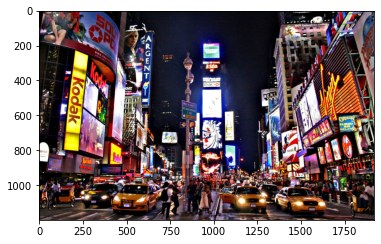

In [11]:
image = Image.open(os.path.join(IMAGE_DIR, 'nysn.jpg')) # new-york.jpg, nys.jpg, car2.jpg, test.png, t.jpeg
print("Original Image")
image = image.convert("RGB")
imshow(image)

(1200, 1920, 3)
Processing 1 images
image                    Shape: (1200, 1920, 3)        min:    0.00000   max:  255.00000  uint8
molded_images            Shape: (1, 768, 768, 3)       min: -123.70000   max:  151.10000  float64
image_metas              Shape: (1, 93)                min:    0.00000   max: 1920.00000  float64
anchors                  Shape: (1, 147312, 4)         min:   -0.47202   max:    1.38858  float32
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Time per image: 15.061889886856079


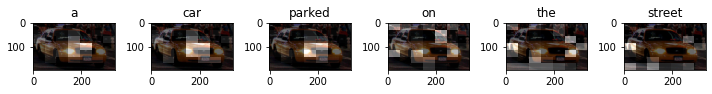

[ 990 1341 1184 1679]
a car parked on the street 
[ 963  419 1176  688]
a white car on the street 
[ 975 1044 1175 1334]
a car parked on the street 
[  33 1370 1004 1899]
a red and white sign 
[ 43  65 916 461]
a red and white sign 
[ 955  685 1193  814]
a man wearing a black shirt 
[ 949  222 1147  500]
a car parked on the street 
[173 779 685 933]
a tall street sign 
[  43  374 1027 1650]
a large red and white building 
[ 995 1799 1181 1911]
a man wearing a black shirt 


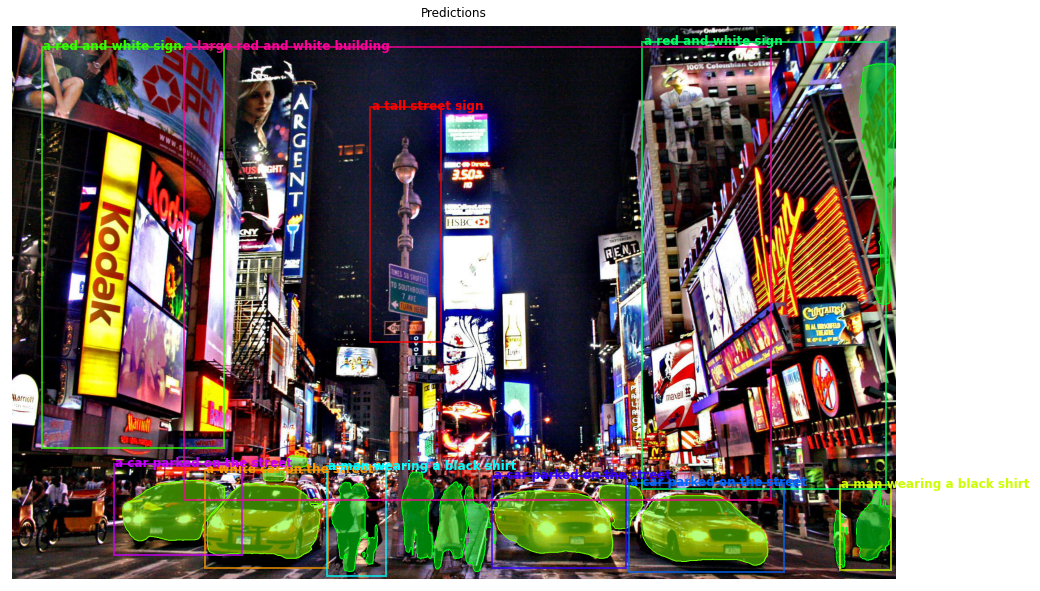

In [12]:
image = np.array(image)
print(image.shape)
s = time.time()
results = model.detect([image], verbose=1)
log("Time per image: {}".format(time.time() - s))
# Display results
r = results[0]
show_attention(image, r['rois'], r['attentions'], r['captions'], r['scores'])
visualize.display_instances(image, r['rois'], r['captions'], r['masks'], r['class_ids'], r['scores'],
                            title="Predictions")

**Detect and visualize images in validation dataset**

Processing 1 images
image                    Shape: (360, 640, 3)          min:    0.00000   max:  255.00000  uint8
molded_images            Shape: (1, 768, 768, 3)       min: -123.70000   max:  151.10000  float64
image_metas              Shape: (1, 93)                min:    0.00000   max:  768.00000  float64
anchors                  Shape: (1, 147312, 4)         min:   -0.47202   max:    1.38858  float32

Original Image and example of attentions



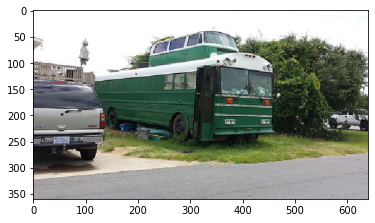

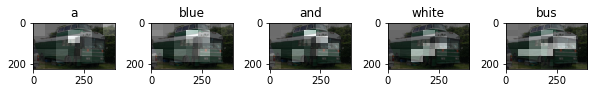

[ 39 107 264 508]
a blue and white bus 
[191 256 249 302]
the wheel of a bus 
[ 50  81 110 113]
a traffic light on a pole 
[ 45 456 233 633]
trees in the background 
[115   1 285 136]
a white car on the road 
[180 135 229 165]
the front wheel of a truck 
[231   6 359 635]
a paved road 
[100  12 138 110]
a building in the background 
[204 362 221 389]
the number on the bus 
[180 558 240 638]
a car parked in the background 
[ 40 225  98 424]
the windshield of a train 


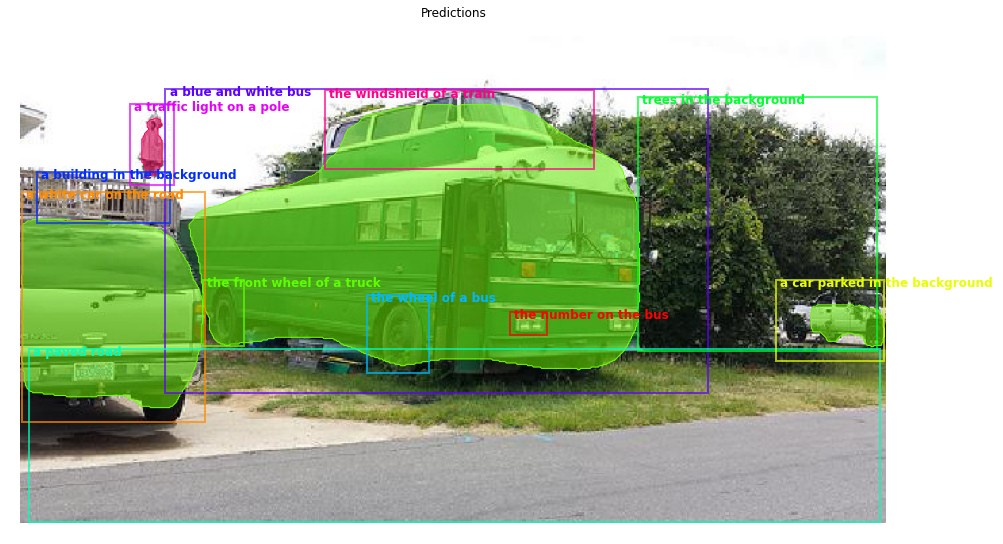

Time per image: 2.2326762676239014


In [13]:
image_id = random.choice(dataset_val.image_ids)
image = dataset_val.load_image(image_id)
s = time.time()
results = model.detect([image], verbose=1)
print('\nOriginal Image and example of attentions\n')
imshow(image)
# Display results
r = results[0]

show_attention(image, r['rois'], r['attentions'], r['captions'], r['scores'])
visualize.display_instances(image, r['rois'], r['captions'], r['masks'], r['class_ids'], r['scores'],
                            gray=False, title="Predictions")
log("Time per image: {}".format(time.time() - s))

## **3.2 Detection and Visualization on videos**

### **Notifications:**

If you want to run codes in this block, please make sure you can connect to a video file


**Define helper functions**

In [14]:
def compute_track_result(pre_result, current_result, threshold=0.3, momentum=0.2):
    pre_boxes = pre_result['rois']
    pre_scores = pre_result['scores']
    pre_captions = pre_result['captions']
    
    cur_boxes = current_result['rois']
    cur_scores = current_result['scores']
    cur_captions = current_result['captions']

    overlaps = utils.compute_overlaps(cur_boxes, pre_boxes)

    tracked_boxes = np.zeros_like(cur_boxes)
    tracked_scores = np.zeros_like(cur_scores)
    tracked_captions = []

    for index, overlap in enumerate(overlaps):
        max_score = np.max(overlap)
        if max_score >= threshold:
            ix = np.where(overlap == max_score)[0][0]
            tracked_boxes[index] = pre_boxes[ix] + (cur_boxes[index] - pre_boxes[ix]) * momentum
            tracked_scores[index] = pre_scores[ix] + (cur_scores[index] - pre_scores[ix]) * momentum
            if cur_scores[index] >= pre_scores[ix]:
                tracked_captions.append(cur_captions[index])
            else:
                tracked_captions.append(pre_captions[ix])
        else:
            tracked_boxes[index] = cur_boxes[index]
            tracked_scores[index] = cur_scores[index] * (1 - momentum)
            tracked_captions.append(cur_captions[index])
    
    current_result['rois'] = tracked_boxes
    current_result['scores'] = tracked_scores
    current_result['captions'] = tracked_captions

    return current_result


def apply_mask(image, mask, color, alpha=0.5):
    # Apply mask to the image
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image


def color_splash(image, masks):
    gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255
    
    if masks.shape[-1] > 0:
        masks = (np.sum(masks, -1, keepdims=True) >= 1)
        splash = np.where(masks, image, gray).astype(np.uint8)
    else:
        splash = gray.astype(np.uint8)
    return splash


def visualize_frame(image, boxes, masks, ids, captions, scores=None, colors=None, gray=False,
              N=5, attentions=None, show_attentions=False, show_captions=True, show_masks=True):
    
    scores = np.array(scores)
    ix = scores.argsort()[::-1]
  
    if N:
        N = np.minimum(N, ix.shape[0])
    else:
        N = ix.shape[0]

    if not N:
        print("No caption instances to display!\n")

    if show_masks:
        if gray:
            image = color_splash(image, masks)
        else:
            if masks.shape[2] == 0:
                print("No mask instances to display!\n")
            mask_colors = colors or Config.MASK_COLORS
            for i in range(masks.shape[2]):
                color = mask_colors[ids[i]-1]
                mask = masks[:, :, i]
                image = apply_mask(image, mask, color)

    if show_captions:
        caption_colors = Config.CAPTION_COLORS
        for i in range(N):
            index = ix[i]
            if not np.any(boxes[index]):
                continue
            color = caption_colors[i]
            y1, x1, y2, x2 = boxes[index]
            image = cv2.rectangle(image, (x1, y1), (x2, y2), color, 1)
            image = cv2.putText(image, captions[index], (x1, y1 + 6), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return image

**Read video and initialize parameters**

Here the code only use the demo video of toronto with only 30s. You can use your own videos by set:


`video_name = '/path/to/your/video.mp4'`

In [15]:
video_path = os.path.join(VIDEO_DIR, 'toronto.mp4')
output_name = video_path.split("/")[-1].split(".")[0]
cap = cv2.VideoCapture(video_path)

prop = cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() else cv2.CAP_PROP_FRAME_COUNT
total = int(cap.get(prop))
frame_rate = int(cap.get(5))
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
internal = 2

out = cv2.VideoWriter(os.path.join(OUTPUT_DIR, output_name + '.mp4'), 
                      cv2.VideoWriter_fourcc(*'MP4V'), frame_rate, (frame_width, frame_height))

print("[INFO] {} total frames in video".format(total))
print("[INFO] Video frame rate: {}".format(frame_rate))
print("[INFO] Video frame width: {}".format(frame_width))
print("[INFO] Video frame height: {}".format(frame_height))
print("[INFO] Video detection internal: {}".format(internal))

[INFO] 2136 total frames in video
[INFO] Video frame rate: 59
[INFO] Video frame width: 1280
[INFO] Video frame height: 720
[INFO] Video detection internal: 2


**Detect on video**

This code block just detect on videos frame by frame and save the result to as a new video, if you want to show the result automatically during the detecting process, pleas add display codes as below shows after `out.write(frame)`



```
# if you are using google colab
out.write(frame)

from google.colab.patches import cv2_imshow
cv2_imshow(frame)
```


```
# if you are running locally
out.write(frame)

cv2.imshow('frame', frame)
```









In [16]:
pre_result = None
for i in range(total):
    if (i + 1) % internal != 0:
        s = time.time()
        ret, frame = cap.read()
        results = model.detect([frame], verbose=0)
        r = results[0]
        if pre_result is not None:
            r = compute_track_result(pre_result, r, threshold=0.3)
        pre_result = r
        if (i % 100 == 0) or i == total - 1:
                print("Currently frame {}/{}, {:.2f} s, fps: {:.2f}".format(
                    i, total, (i + 1) / frame_rate, internal / (time.time() - s)))
    else:
        r = pre_result
    frame = visualize_frame(frame, r['rois'], r['masks'], r['class_ids'],
                            r['captions'], scores=r['scores'], gray=True,
                            show_masks=True, show_captions=True, N=3)
    out.write(frame)
    # Add display codes here

print("Video analysis finished, now you can download detected video from the output directory!")   

Currently frame 0/2136, 0.02 s, fps: 2.89
Currently frame 100/2136, 1.71 s, fps: 3.43
Currently frame 200/2136, 3.41 s, fps: 3.39
Currently frame 300/2136, 5.10 s, fps: 3.27
Currently frame 400/2136, 6.80 s, fps: 3.39
Currently frame 500/2136, 8.49 s, fps: 3.45
Currently frame 600/2136, 10.19 s, fps: 3.33
Currently frame 700/2136, 11.88 s, fps: 3.39
Currently frame 800/2136, 13.58 s, fps: 3.40
Currently frame 900/2136, 15.27 s, fps: 3.33
Currently frame 1000/2136, 16.97 s, fps: 3.47
Currently frame 1100/2136, 18.66 s, fps: 3.53
Currently frame 1200/2136, 20.36 s, fps: 3.47
Currently frame 1300/2136, 22.05 s, fps: 3.39
Currently frame 1400/2136, 23.75 s, fps: 3.41
Currently frame 1500/2136, 25.44 s, fps: 3.41
Currently frame 1600/2136, 27.14 s, fps: 3.51
Currently frame 1700/2136, 28.83 s, fps: 3.48
Currently frame 1800/2136, 30.53 s, fps: 3.38
Currently frame 1900/2136, 32.22 s, fps: 3.45
Currently frame 2000/2136, 33.92 s, fps: 3.39
Currently frame 2100/2136, 35.61 s, fps: 3.40
Video 

In [17]:
# close unuse connections
cap.release()
out.release()
cv2.destroyAllWindows()

# **4 Evaluate Model**

Evaluate MACA on CocoVG validation dataset


*   Evaluate mask by mAP
*   Evaluate caption by BLEU, CIDEr, METEOR, ROUGE



## **4.1 Define helper functions**

In [18]:
def unmold_detections(caption_detections, mask_detections, maca_masks, maca_captions,
                      original_image_shape, image_shape, window):
    """Reformats the detections of one image from the format of the neural
    network output to a format suitable for use in the rest of the
    application.

    detections: [N, (y1, x1, y2, x2, score)] in normalized coordinates
    maca_mask: [N, height, width, ]
    maca_caption: [N, MAX_LENGTH, VOCAB_SIZE]
    original_image_shape: [H, W, C] Original image shape before resizing
    image_shape: [H, W, C] Shape of the image after resizing and padding
    window: [y1, x1, y2, x2] Pixel coordinates of box in the image where the real
            image is excluding the padding.

    mask_rois: [N, 4]

    Returns:
    boxes: [N, (y1, x1, y2, x2)] Bounding boxes in pixels
    class_ids: [N] Integer class IDs for each bounding box
    scores: [N] Float probability scores of the class_id
    masks: [height, width, num_instances] Instance masks
    """
    # How many detections do we have?
    # Detections array is padded with zeros. Find the first idx == 0.
    zero_ix = np.where(caption_detections[:, 4] == 0)[0]
    N = zero_ix[0] if zero_ix.shape[0] > 0 else caption_detections.shape[0]

    # Extract boxes, scores, and class-specific masks
    caption_boxes = caption_detections[:N, :4]
    caption_scores = caption_detections[:N, 4]
    captions = maca_captions[:N, :, :]

    mask_zero_ix = np.where(mask_detections[:, 4] == 0)[0]
    N = mask_zero_ix[0] if mask_zero_ix.shape[0] > 0 else mask_detections.shape[0]
    mask_boxes = mask_detections[:N, :4]
    mask_class_ids = mask_detections[:N, 4].astype(np.int32)
    mask_scores = mask_detections[:N, 5]
    masks = maca_masks[np.arange(N), :, :, mask_class_ids]

    # Translate normalized coordinates in the resized image to pixel
    # coordinates in the original image before resizing
    window = utils.norm_boxes(window, image_shape[:2])
    wy1, wx1, wy2, wx2 = window
    shift = np.array([wy1, wx1, wy1, wx1])
    wh = wy2 - wy1  # window height
    ww = wx2 - wx1  # window width
    scale = np.array([wh, ww, wh, ww])
    # Convert boxes to normalized coordinates on the window
    caption_boxes = np.divide(caption_boxes - shift, scale)
    mask_boxes = np.divide(mask_boxes - shift, scale)
    # Convert boxes to pixel coordinates on the original image
    caption_boxes = utils.denorm_boxes(caption_boxes, original_image_shape[:2])
    mask_boxes = utils.denorm_boxes(mask_boxes, original_image_shape[:2])

    if caption_boxes.shape[0] >= 2:
        ix = utils.non_max_suppression(caption_boxes, caption_scores, 0.2)
        caption_boxes = caption_boxes[ix]
        caption_scores = caption_scores[ix]
        captions = captions[ix]

    # Filter out detections with zero area. Happens in early training when
    # network weights are still random
    exclude_ix = np.where((caption_boxes[:, 2] - caption_boxes[:, 0]) *
                        (caption_boxes[:, 3] - caption_boxes[:, 1]) <= 50)[0]
    if exclude_ix.shape[0] > 0:
        caption_boxes = np.delete(caption_boxes, exclude_ix, axis=0)
        caption_scores = np.delete(caption_scores, exclude_ix, axis=0)
        captions = np.delete(captions, exclude_ix, axis=0)

    # ix = utils.non_max_suppression(mask_boxes, mask_scores, 0.3)
    # masks = masks[:, :, ix]
    # mask_scores = mask_scores[ix]

    # Filter out mask_rois with zero area.
    mask_exclude_ix = np.where(
        (mask_boxes[:, 2] - mask_boxes[:, 0]) * (mask_boxes[:, 3] - mask_boxes[:, 1]) <= 0)[0]
    if mask_exclude_ix.shape[0] > 0:
        masks = np.delete(masks, mask_exclude_ix, axis=2)
        mask_boxes = np.delete(mask_boxes, mask_exclude_ix, axis=0)
        mask_class_ids = np.delete(mask_class_ids, mask_exclude_ix, axis=0)
        mask_scores = np.delete(mask_scores, mask_exclude_ix, axis=0)

    N = masks.shape[0]
    # Resize masks to original image size and set boundary threshold.
    full_masks = []
    for i in range(N):
        # Convert neural network mask to full size mask
        full_mask = utils.unmold_mask(masks[i], mask_boxes[i], original_image_shape)
        full_masks.append(full_mask)
    full_masks = np.stack(full_masks, axis=-1) \
        if full_masks else np.empty(original_image_shape[:2] + (0,))

    # Extract captions
    captions_sequences = np.argmax(captions, axis=2)
    captions = tokenizer.sequences_to_texts(captions_sequences)
    for i, caption in enumerate(captions):
        captions[i] = caption.split('<end>')[0]
        captions[i] = captions[i].replace('<unk>', '')

    return caption_boxes, caption_scores, full_masks, captions, mask_class_ids, mask_scores, mask_boxes


def predict(images, verbose=0):
    molded_images, image_metas, windows = model.mold_inputs(images)

    image_shape = molded_images[0].shape

    anchors = model.get_anchors(image_shape)
    anchors = np.broadcast_to(anchors, (1,) + anchors.shape)

    outputs = model.model.predict([molded_images, image_metas, anchors])

    molded_images = molded_images[0]
    original_image_shape = image.shape
    image_shape = molded_images.shape
    window = windows[0]

    caption_detections = outputs[0][0]
    mask_detections = outputs[5][0]
    masks = outputs[4][0]
    captions = outputs[2][0]

    caption_boxes, caption_scores, full_masks, captions, mask_class_ids, mask_scores, mask_boxes = \
        unmold_detections(caption_detections, mask_detections, masks, captions, image.shape, 
                          molded_images.shape, window)
    
    return caption_boxes, caption_scores, full_masks, captions, mask_class_ids, mask_scores, mask_boxes


def filter_captions(pre, gt, pre_c, gt_c, id, pre_captions_final, gt_captions_final, threshold=0.5, ):
    overlaps = utils.compute_overlaps(gt, pre)
    for i in range(len(gt)):
        title = str(id) + '-' + str(i)
        overlap = overlaps[i]
        idx = np.where(overlap >= threshold)[0]
        if len(idx) > 0:
            gt_captions_final[title] = [gt_c[i]]
            pre_captions_final[title] = [pre_c[j] for j in idx]
    
    return pre_captions_final, gt_captions_final

## **4.2 Calculate Metrics**



*   mAP
*   BLEU
*   ROUGE
*   CIDEr



In [19]:
from tqdm import tqdm
overall_AP = []
overall_recalls = []
overall_F1_scores = []

pre_captions_final = {}
gt_captions_final = {}
dataset = dataset_train
for id in tqdm(range(1000)):
    image = dataset.load_image(id)
    gt_masks, gt_class_ids = dataset.load_mask(id)
    gt_captions = dataset.load_captions(id)
    gt_captions = tokenizer.sequences_to_texts(gt_captions)
    for i, caption in enumerate(gt_captions):
        gt_captions[i] = caption.split('<end>')[0]
        gt_captions[i] = gt_captions[i].replace('<start> ', '')

    gt_mask_boxes = utils.extract_bboxes(gt_masks)
    gt_caption_boxes, _ = dataset.load_caption_boxes(id)

    caption_boxes, caption_scores, full_masks, captions, mask_class_ids, mask_scores, mask_boxes = \
            predict([image], verbose=0)
    
    pre_captions_final, gt_captions_final = filter_captions(caption_boxes, gt_caption_boxes,
                                                            captions, gt_captions, id, 
                                                            pre_captions_final, gt_captions_final,
                                                            threshold=0.75)
        
    AP, precisions, recalls, overlaps = utils.compute_ap(gt_mask_boxes, gt_class_ids, gt_masks, 
                                                      mask_boxes, mask_class_ids, mask_scores, full_masks,
                                                      iou_threshold=0.25)
    overall_AP.append(AP)
    overall_recalls.append(np.mean(recalls))
    overall_F1_scores.append((2* (np.mean(precisions) * np.mean(recalls)))/(np.mean(precisions) + np.mean(recalls)))

100%|██████████| 1000/1000 [10:32<00:00,  1.58it/s]


In [20]:
result = eval(pre_captions_final, gt_captions_final)
mAP = np.mean(overall_AP)
print("[INFO] MACA with {} as FEN.".format(InferenceConfig.BACKBONE))
print("[Metric] mAP: {:.4f}".format(mAP * 100))
print("[Metric] F1-Score: {:.4f}".format(np.mean(overall_F1_scores) * 100))
print("[Metric] BLEU-1: {:.4f}".format(result['bleu'][0] * 2 * 100))
print("[Metric] BLEU-2: {:.4f}".format(result['bleu'][1] * 3 * 100))
print("[Metric] BLEU-3: {:.4f}".format(result['bleu'][2] * 4 * 100))
print("[Metric] BLEU-4: {:.4f}".format(result['bleu'][3] * 5 * 100))
print("[Metric] CIDEr: {:.4f}".format(result['cider'] * 1 * 100))
print("[Metric] ROUGE: {:.4f}".format(result['rouge'] * 1 * 100))

{'testlen': 29718, 'reflen': 29566, 'guess': [29718, 23912, 18113, 12384], 'correct': [9125, 2187, 602, 158]}
ratio: 1.0051410403841912
[INFO] MACA with efficientnet-b3 as FEN.
[Metric] mAP: 61.6978
[Metric] F1-Score: 54.3318
[Metric] BLEU-1: 61.4106
[Metric] BLEU-2: 50.2741
[Metric] BLEU-3: 39.0911
[Metric] BLEU-4: 29.3719
[Metric] CIDEr: 78.8636
[Metric] ROUGE: 40.8582
